In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np
import xarray as xr

In [2]:
_gender = 'Female'
mc_type = 'CGN'

In [3]:
gene_name_to_id = joblib.load('240112_DMG_CEF/gene_name_to_id_dict')
gene_id_to_name = joblib.load('240112_DMG_CEF/gene_id_to_name_dict')

gene_meta_path = '/home/qzeng/project/aging/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz'
gene_meta = pd.read_csv(gene_meta_path, index_col ='gene_id', sep='\t')

In [4]:
data = xr.open_zarr(f'{mc_type}.{_gender}.AgingMajorType.Anova.Result.zarr')

In [5]:
if _gender == 'Male':
    meta = pd.read_csv('/home/qzeng/project/aging/metadata/240104_mC_META.csv', index_col = 0)
    use_cts = joblib.load(f"/home/qzeng/project/aging/metadata/mc_use_cts")
elif _gender == 'Female':
    meta = pd.read_csv('/home/qzeng/project/aging/metadata/240104_m3C_META.csv', index_col = 0)
    use_cts = joblib.load(f"/home/qzeng/project/aging/metadata/m3c_use_cts")

In [6]:
use_cts = ['DG Glut','CA1-ProS Glut','CA3 Glut','L2/3 IT CTX Glut','L6 IT CTX Glut','L6 CT CTX Glut']

Text(0.5, 0.98, 'Young-Old Domain Genes')

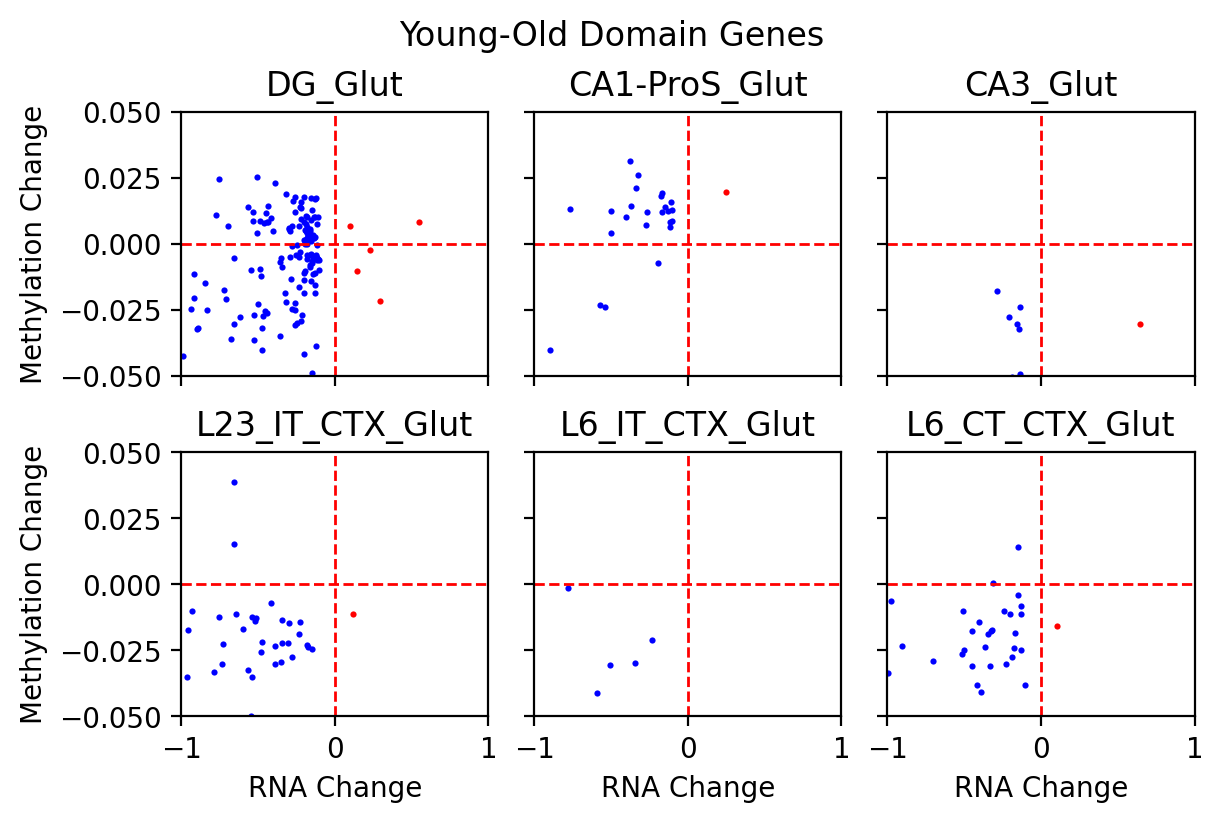

In [7]:
ncols = 3 
nrows = 2

kwargs = {'rasterized':True}
x = 'log2(18mo/2mo)'
y = 'methylation_change'

fig, axes = plt.subplots(figsize = (2*ncols,2*nrows), ncols = ncols, nrows = nrows, 
                         dpi = 200, constrained_layout = True, sharey= True, sharex= True)
for use_ct, ax in zip(use_cts, axes.ravel()):
    ct = use_ct.replace(' ','_').replace('/','')
    domain_degs = pd.read_csv(f'New.Domain.Genes.Expression/{ct}/DiffExpress.DomainGene.csv', index_col = 0)
    use_data = data.sel(cell_type = use_ct)
    anova_df = use_data['anova_results'].to_pandas()
    # filter gene_length
    anova_df['celltype'] = use_ct
    anova_df['methylation_change'] = anova_df['18mo'] - anova_df['8wk']
    anova_df['abs_change'] = abs(anova_df['methylation_change'])
    anova_df['gene_name'] = anova_df.index.map(gene_id_to_name)
    anova_df['-log10(pvalue)'] = -np.log10(anova_df['pvalue'] + 1e-100)

    deg_anova_df = anova_df[anova_df['gene_name'].isin(domain_degs.index)]
    domain_degs.index = [gene_name_to_id[gene_name] for gene_name in domain_degs.index]
    result = pd.concat([domain_degs['log2(18mo/2mo)'], deg_anova_df['methylation_change']], axis = 1)
    
    deg_anova_df = deg_anova_df[deg_anova_df['pvalue'] < 0.05]
    result = result.loc[deg_anova_df.index]
    
    sns.scatterplot(data=result[result['log2(18mo/2mo)'] > 0], 
              x = x, y= y, 
              linewidth = 0,
              legend=None,
              ax= ax, 
              s = 5,
              color = 'red',
              **kwargs)
    
    sns.scatterplot(data=result[result['log2(18mo/2mo)'] < 0], 
              x = x, y= y, 
              linewidth = 0,
              legend=None,
              ax= ax, 
              s = 5,
              color = 'blue',
              **kwargs)
    
    
    ax.set(xlim = (-1,1), ylim = (-0.05, 0.05), 
           xlabel = 'RNA Change', ylabel = 'Methylation Change')
    ax.axhline(y = 0, ls = '--', c  = 'r', lw = 1)
    ax.axvline(x = 0, ls = '--', c  = 'r', lw = 1)
    ax.set_title(f"{ct}")
    
plt.suptitle('Young-Old Domain Genes')